# Spectrogram analysis

This notebook performs exploratory and quantitative analysis of processed audio spectrograms stored under `data/spectrograms/`.

Sections: environment, discover files, visualize examples, compute statistics, feature extraction, embeddings, clustering, simple baseline, inversion/playback, and saving results.

## 1) Environment setup & imports
Install dependencies if you haven't already and run imports. The recommended environment is the repo's `requirements.txt`.

PowerShell quick setup (run in terminal):
```
powershell
python -m pip install --upgrade pip
python -m pip install -r requirements.txt
# Optional: additional packages for analysis
python -m pip install umap-learn scikit-learn seaborn tqdm
```

In [1]:
# ENV: imports and settings
import sys, os, time, json, logging, warnings
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import joblib

# Optional audio libs
import librosa
import librosa.display

# ML / DR libs (import when available)
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

try:
    import umap
except Exception:
    umap = None

# Notebook-level settings
SEED = 42
np.random.seed(SEED)
import random
random.seed(SEED)

logging.basicConfig(level=logging.INFO)
warnings.filterwarnings('ignore')
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (10, 4)

ROOT = Path('..').resolve() if Path('.').resolve().name == 'notebooks' else Path('.').resolve()
DATA_SPECS = ROOT / 'data' / 'spectrograms'
RESULTS_DIR = ROOT / 'results'
RESULTS_DIR.mkdir(exist_ok=True)
print('ROOT =', ROOT)
print('Spectrogram dir:', DATA_SPECS)

c:\Users\Darling\DATA SCIENCE PROJECTS\VSCodeProjects\GA_Frog_ID_Data_Prep\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ROOT = C:\Users\Darling\DATA SCIENCE PROJECTS\VSCodeProjects\GA_Frog_ID_Data_Prep
Spectrogram dir: C:\Users\Darling\DATA SCIENCE PROJECTS\VSCodeProjects\GA_Frog_ID_Data_Prep\data\spectrograms


## 2) Discover spectrogram files and loader helper
Look for common spectrogram formats: `.npy`, `.npz` and (if present) `.h5` or pickles. We provide a `load_spectrogram(path)` wrapper that attempts to load a variety of formats and returns a dict with keys: `S` (magnitude or log-mel array), `sr` (sample rate if available), `meta`.

In [2]:
import numpy as np, os, json
from pathlib import Path
import soundfile as sf

def load_npy(path):
    arr = np.load(path, allow_pickle=True)
    return arr

def load_spectrogram(p):
    p = Path(p)
    meta = {}
    if p.suffix.lower() == '.npy':
        try:
            arr = np.load(p, allow_pickle=True)
        except Exception as e:
            raise
        # arr may be a raw spectrogram or a dict saved with np.save(np.array(dict))
        if isinstance(arr, np.ndarray) and arr.dtype == object:
            # single object saved; attempt to extract fields
            obj = arr.tolist()
            if isinstance(obj, dict):
                S = obj.get('S') or obj.get('spec') or obj.get('melspec')
                meta.update({k:v for k,v in obj.items() if k!='S' and k!='spec' and k!='melspec'})
            else:
                S = np.asarray(obj)
        elif isinstance(arr, np.ndarray):
            S = arr
        else:
            S = np.asarray(arr)
        return {'S': S, 'sr': None, 'meta': meta}
    elif p.suffix.lower() == '.npz':
        with np.load(p, allow_pickle=True) as d:
            if 'S' in d:
                S = d['S']
                meta = {k: d[k].tolist() if hasattr(d[k], 'tolist') else d[k] for k in d.files if k!='S'}
            else:
                # pick first array
                k = d.files[0]
                S = d[k]
        return {'S': S, 'sr': None, 'meta': meta}
    else:
        raise RuntimeError(f'Unsupported spectrogram format: {p.suffix}')

# discover files
spec_paths = list(DATA_SPECS.rglob('*.npy')) + list(DATA_SPECS.rglob('*.npz'))
spec_paths = sorted(set(spec_paths))
print(f'Found {len(spec_paths)} spectrogram files under {DATA_SPECS}')

Found 1400 spectrogram files under C:\Users\Darling\DATA SCIENCE PROJECTS\VSCodeProjects\GA_Frog_ID_Data_Prep\data\spectrograms


## 3) Inspect dataset structure & metadata
Build a metadata DataFrame with species inferred from subfolder names and basic shape/dtype info.

In [4]:
rows = []
for p in tqdm(spec_paths):
    rel = p.relative_to(ROOT) if p.exists() else p
    species = p.parent.name
    try:
        info = load_spectrogram(p)
        S = info['S']
        shape = S.shape
        dtype = getattr(S, 'dtype', None)
    except Exception as e:
        S = None
        shape = None
        dtype = None
    rows.append({'file_id': p.stem, 'species': species, 'spectrogram_path': str(rel), 'shape': shape, 'dtype': str(dtype)})
meta_df = pd.DataFrame(rows)
print(meta_df.shape)
display(meta_df.head())
# quick counts
print('Counts per species:'),
print(meta_df['species'].value_counts())

  0%|          | 2/1400 [00:00<02:02, 11.43it/s]

100%|██████████| 1400/1400 [01:38<00:00, 14.24it/s]



(1400, 5)


,file_id,species,spectrogram_path,shape,dtype
0,03-Bullfrog-call-1,american_bullfrog,data\spectrograms\american_bullfrog\03-Bullfro...,"(64, 431)",float32
1,375155,american_bullfrog,data\spectrograms\american_bullfrog\375155.npy,"(64, 431)",float32
2,American_Bullfrog_(Rana_catesbeiana)_-_Mating_...,american_bullfrog,data\spectrograms\american_bullfrog\American_B...,"(64, 431)",float32
3,Bellowing_Bullfrog_sends_water_flying!,american_bullfrog,data\spectrograms\american_bullfrog\Bellowing_...,"(64, 431)",float32
4,"Bullfrog,_fastest_and_largest_N._American_frog.",american_bullfrog,"data\spectrograms\american_bullfrog\Bullfrog,_...","(64, 431)",float32


Counts per species:
species
american_toad                  183
green_tree_frog                180
northern_cricket_frog          164
copes_gray_treefrog            137
american_bullfrog              123
not_frogs                      117
spring_peeper                  106
eastern_narrow_mouthed_toad     97
green_frog                      84
pickerel_frog                   57
fowlers_toad                    40
southern_leopard_frog           36
upland_chorus_frog              32
bird_voiced_tree_frog           27
eastern_spadefoot_toad          17
Name: count, dtype: int64


## 4) Visualize example spectrograms
Plot a small grid of representative spectrograms (log scale display).

Saved example figure to C:\Users\Darling\DATA SCIENCE PROJECTS\VSCodeProjects\GA_Frog_ID_Data_Prep\results\spectrogram_examples_1762228124.png


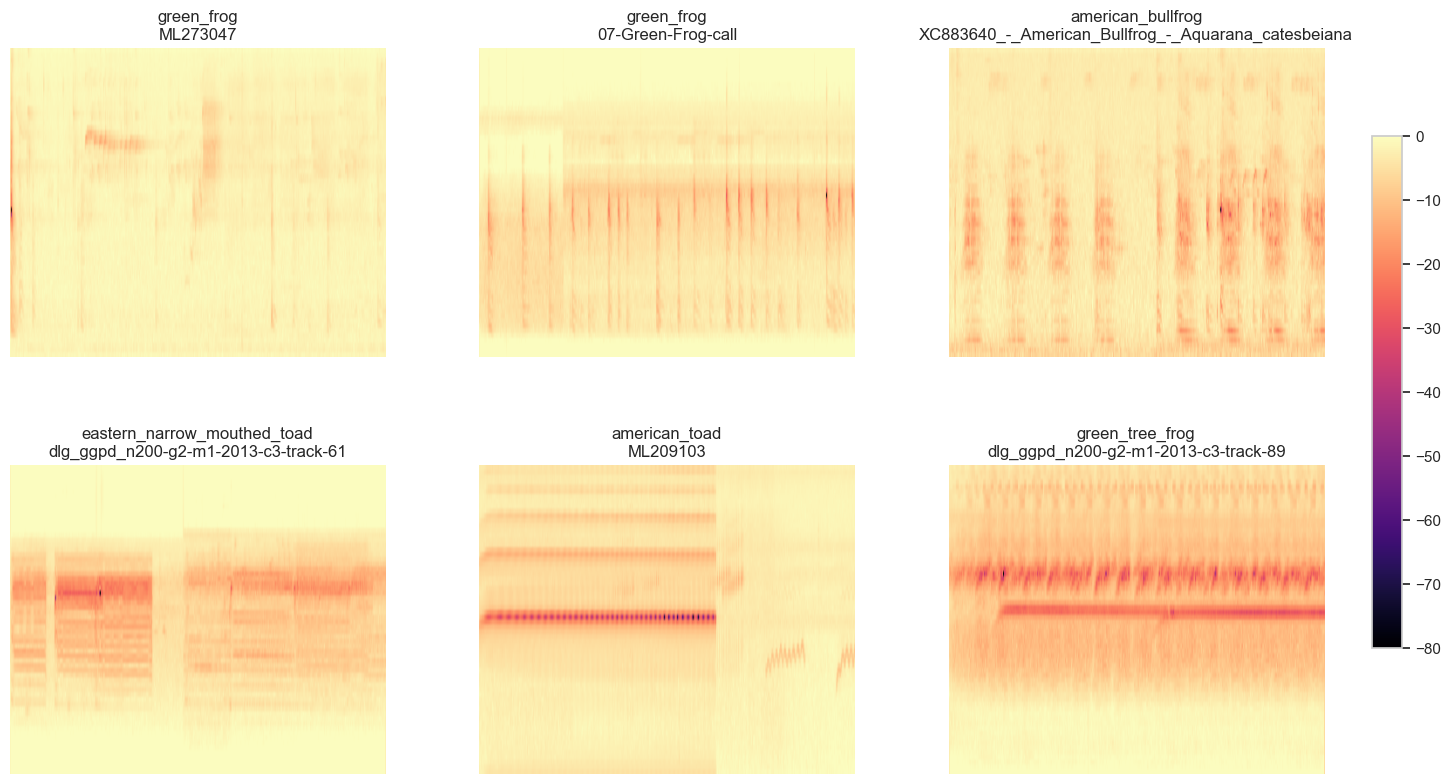

In [14]:
import math
n_examples = 6
examples = meta_df.dropna(subset=['shape']).sample(min(n_examples, len(meta_df)), random_state=SEED)
# create grid and reserve space on the right for a single colorbar
fig, axes = plt.subplots(2, 3, figsize=(15, 8), constrained_layout=False)
axes = axes.flatten()
for ax, (_, r) in zip(axes, examples.iterrows()):
    p = Path(r['spectrogram_path'])
    try:
        out = load_spectrogram(ROOT / p)
        S = out['S']
        # display log amplitude if positive
        if np.nanmin(S) >= 0:
            disp = librosa.power_to_db(S, ref=np.max) if S.dtype.kind != 'O' else np.log1p(S)
        else:
            disp = librosa.amplitude_to_db(S, ref=np.max) if S.dtype.kind != 'O' else S
    except Exception as e:
        ax.set_title('failed to load')
        ax.axis('off')
        continue
    im = ax.imshow(disp, origin='lower', aspect='auto', cmap='magma')
    ax.set_title(f"{r['species']}\n{r['file_id']}")
    ax.axis('off')
# place a single colorbar to the right so it doesn't overlap subplots
cbar_ax = fig.add_axes([0.92, 0.18, 0.02, 0.64])
fig.colorbar(im, cax=cbar_ax)
# tighten layout but leave space for colorbar (use rect to avoid overlap)
plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.subplots_adjust(wspace=0.25, hspace=0.35)
out_png = RESULTS_DIR / f'spectrogram_examples_{int(time.time())}.png'
fig.savefig(out_png, dpi=150, bbox_inches='tight')
print('Saved example figure to', out_png)

## 5) Compute global statistics (mean, std, approximate SNR)
Compute per-file stats and add them to `meta_df`. SNR is approximated as 20*log10(signal_rms / noise_rms) where noise_rms is estimated from low-percentile energy frames.

In [6]:
def file_stats_from_S(S):
    S = np.asarray(S, dtype=float)
    mean = float(np.nanmean(S))
    std = float(np.nanstd(S))
    med = float(np.nanmedian(S))
    p10 = float(np.nanpercentile(S, 10))
    p90 = float(np.nanpercentile(S, 90))
    # Approx SNR: ratio of mean energy to low-percentile energy
    noise_floor = max(p10, 1e-10)
    snr_db = 20.0 * np.log10(max(mean, 1e-10) / noise_floor) if noise_floor>0 else np.nan
    return dict(mean=mean, std=std, med=med, p10=p10, p90=p90, snr_db=snr_db)

stats_rows = []
for i, r in tqdm(meta_df.iterrows(), total=len(meta_df)):
    p = Path(r['spectrogram_path'])
    try:
        out = load_spectrogram(ROOT / p)
        S = out['S']
        s = file_stats_from_S(S)
    except Exception as e:
        s = dict(mean=np.nan, std=np.nan, med=np.nan, p10=np.nan, p90=np.nan, snr_db=np.nan)
    stats_rows.append(s)
stats_df = pd.DataFrame(stats_rows)
meta_df = pd.concat([meta_df, stats_df], axis=1)
display(meta_df.head())
out_csv = RESULTS_DIR / 'spectrogram_file_stats.csv'
meta_df.to_csv(out_csv, index=False)
print('Wrote', out_csv)

100%|██████████| 1400/1400 [00:24<00:00, 56.16it/s]



,file_id,species,spectrogram_path,shape,dtype,mean,std,med,p10,p90,snr_db
0,03-Bullfrog-call-1,american_bullfrog,data\spectrograms\american_bullfrog\03-Bullfro...,"(64, 431)",float32,-49.717791,21.032268,-47.212629,-80.000000,-23.701000,0.0
1,375155,american_bullfrog,data\spectrograms\american_bullfrog\375155.npy,"(64, 431)",float32,-32.241436,17.034721,-29.467671,-55.958587,-12.018891,0.0
2,American_Bullfrog_(Rana_catesbeiana)_-_Mating_...,american_bullfrog,data\spectrograms\american_bullfrog\American_B...,"(64, 431)",float32,-46.386173,12.751914,-46.062386,-62.084347,-32.499207,0.0
3,Bellowing_Bullfrog_sends_water_flying!,american_bullfrog,data\spectrograms\american_bullfrog\Bellowing_...,"(64, 431)",float32,-38.740597,12.934788,-40.502079,-54.415358,-20.121509,0.0
4,"Bullfrog,_fastest_and_largest_N._American_frog.",american_bullfrog,"data\spectrograms\american_bullfrog\Bullfrog,_...","(64, 431)",float32,-39.165475,21.273866,-34.259836,-80.000000,-16.015167,0.0


Wrote C:\Users\Darling\DATA SCIENCE PROJECTS\VSCodeProjects\GA_Frog_ID_Data_Prep\results\spectrogram_file_stats.csv


## 6) Temporal and frequency marginals
Compute frequency marginal (energy per frequency bin) and temporal marginal (energy per frame) and save averages.

100%|██████████| 1400/1400 [00:08<00:00, 170.22it/s]



Saved spectrogram_summary.csv
Saved avg_frequency_marginal.png
Saved avg_frequency_marginal.png


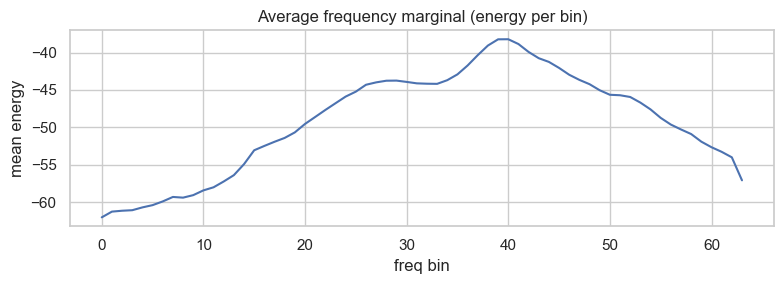

In [7]:
def marginals(S):
    S = np.asarray(S, dtype=float)
    freq_marg = np.nanmean(S, axis=1) if S.ndim==2 else np.nanmean(S, axis=0)
    time_marg = np.nanmean(S, axis=0) if S.ndim==2 else np.nanmean(S, axis=1)
    return freq_marg, time_marg

# compute averages over a small subset to avoid heavy compute during exploration
freq_aggs = []
time_aggs = []
for i, r in tqdm(meta_df.iterrows(), total=len(meta_df)):
    if pd.isna(r['shape']):
        freq_aggs.append(None); time_aggs.append(None); continue
    try:
        out = load_spectrogram(ROOT / Path(r['spectrogram_path']))
        S = out['S']
        f_m, t_m = marginals(S)
        freq_aggs.append(f_m)
        time_aggs.append(t_m)
    except Exception as e:
        freq_aggs.append(None); time_aggs.append(None)

meta_df['freq_marginal'] = freq_aggs
meta_df['time_marginal'] = time_aggs
# save a reduced CSV with shapes and snr only
meta_df[['file_id','species','shape','mean','std','snr_db']].to_csv(RESULTS_DIR / 'spectrogram_summary.csv', index=False)
print('Saved spectrogram_summary.csv')
# plot the average frequency marginal across all files (for those with marginals)
all_freqs = [f for f in freq_aggs if f is not None]
if all_freqs:
    # pad to same length by trimming/zero-pad to median length
    lengths = [len(f) for f in all_freqs]
    medlen = int(np.median(lengths))
    proc = [f[:medlen] if len(f)>=medlen else np.pad(f, (0, medlen-len(f))) for f in all_freqs]
    avg_freq = np.nanmean(proc, axis=0)
    plt.figure(figsize=(8,3)); plt.plot(avg_freq); plt.title('Average frequency marginal (energy per bin)'); plt.xlabel('freq bin'); plt.ylabel('mean energy'); plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'avg_frequency_marginal.png', dpi=150)
    print('Saved avg_frequency_marginal.png')

## 7) Feature extraction (log-mel, centroid, bandwidth, contrast, rolloff, temporal stats)
Extract consistent feature vectors per file and save as CSV/NPZ.

In [8]:
import librosa.feature as lf

def extract_features_from_S(S, sr=22050, hop_length=512, n_mels=64):
    # if S is power (mel) convert to linear if needed; assume S is linear magnitude or power
    S = np.asarray(S, dtype=float)
    # compute log-mel: if S has shape (n_mels, frames) we can use as-is, otherwise compute from waveform (skip here)
    # We compute stats from S: spectral centroid, bandwidth, rolloff expect time-series input, so we approximate by reconstructing a pseudo-waveform is not ideal.
    feats = {}
    # summary stats over S
    feats['mean_energy'] = float(np.nanmean(S))
    feats['std_energy'] = float(np.nanstd(S))
    feats['median_energy'] = float(np.nanmedian(S))
    # frequency-wise mean & top-3 peak bins
    freq_mean = np.nanmean(S, axis=1) if S.ndim==2 else np.nanmean(S, axis=0)
    top_bins = np.argsort(freq_mean)[-3:][::-1] if freq_mean is not None else []
    for i, b in enumerate(top_bins): feats[f'top_bin_{i+1}'] = int(b)
    # simple temporal moments
    if S.ndim==2:
        t_mean = np.nanmean(S, axis=0)
        feats['time_mean_mean'] = float(np.nanmean(t_mean))
        feats['time_mean_std'] = float(np.nanstd(t_mean))
    return feats

feat_rows = []
for i, r in tqdm(meta_df.iterrows(), total=len(meta_df)):
    if pd.isna(r['shape']):
        feat_rows.append({'file_id': r['file_id'], 'species': r['species']})
        continue
    try:
        out = load_spectrogram(ROOT / Path(r['spectrogram_path']))
        S = out['S']
        feats = extract_features_from_S(S)
        feats.update({'file_id': r['file_id'], 'species': r['species']})
    except Exception as e:
        feats = {'file_id': r['file_id'], 'species': r['species']}
    feat_rows.append(feats)
features_df = pd.DataFrame(feat_rows)
features_df.to_csv(RESULTS_DIR / 'spectrogram_features.csv', index=False)
print('Wrote spectrogram_features.csv')

100%|██████████| 1400/1400 [00:16<00:00, 84.98it/s] 



Wrote spectrogram_features.csv


## 8) Dimensionality reduction: PCA / t-SNE / UMAP
Run DR on the features DataFrame after filling NA and scaling.

Saved embedding figures


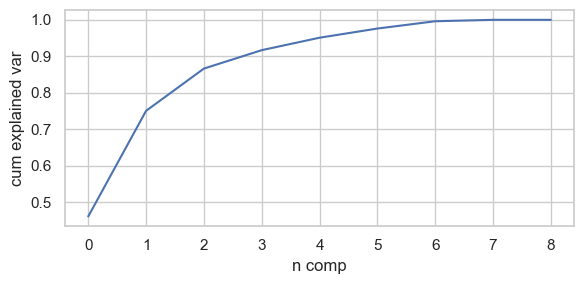

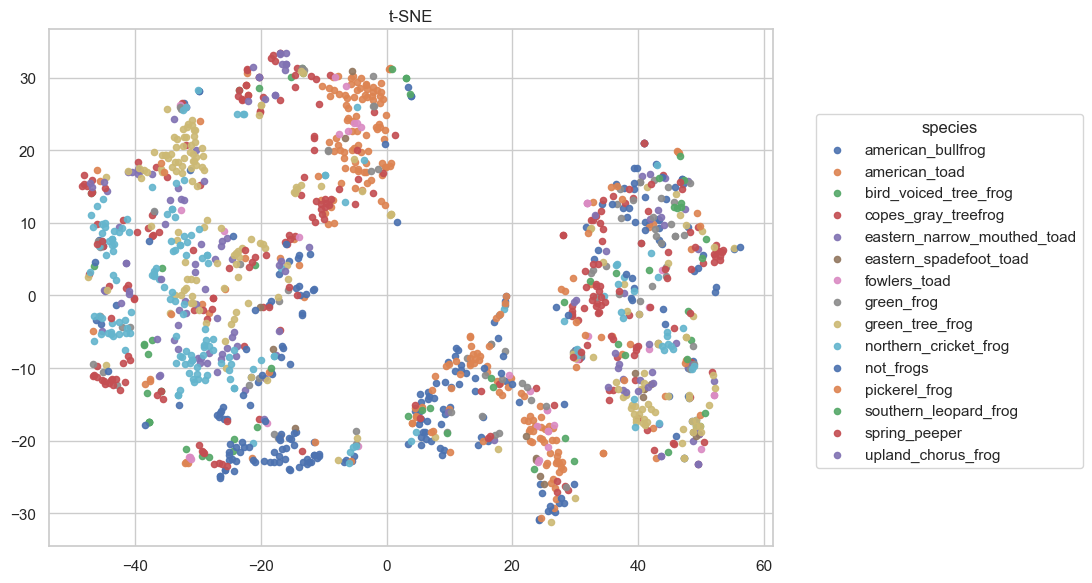

In [13]:
from sklearn.impute import SimpleImputer
# prepare numeric matrix
num_cols = [c for c in features_df.columns if c not in ('file_id','species')]
X = features_df[num_cols].values
imp = SimpleImputer(strategy='mean')
X_im = imp.fit_transform(X)
scaler = StandardScaler()
Xz = scaler.fit_transform(X_im)
# PCA
pca = PCA(n_components=min(50, Xz.shape[1]))
pca.fit(Xz)
explained = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(6,3)); plt.plot(explained); plt.xlabel('n comp'); plt.ylabel('cum explained var'); plt.grid(True); plt.tight_layout(); plt.savefig(RESULTS_DIR / 'pca_explained.png', dpi=150)
# t-SNE (small datasets only) - plot with legend outside to avoid overlaps
if Xz.shape[0] <= 2000:
    ts = TSNE(n_components=2, random_state=SEED, perplexity=30)
    X_tsne = ts.fit_transform(Xz)
    uniq = list(pd.Series(features_df['species']).unique())
    palette = sns.color_palette(n_colors=len(uniq))
    fig_tsne, ax_tsne = plt.subplots(figsize=(8,6))
    for sp, col in zip(uniq, palette):
        idx = features_df['species'] == sp
        ax_tsne.scatter(X_tsne[idx,0], X_tsne[idx,1], label=sp, s=20, color=col, alpha=0.9)
    ax_tsne.set_title('t-SNE')
    # place legend to the right
    fig_tsne.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), title='species')
    fig_tsne.tight_layout()
    fig_tsne.savefig(RESULTS_DIR / 'tsne_scatter.png', dpi=150, bbox_inches='tight')
# UMAP if available - similar treatment
if umap is not None:
    reducer = umap.UMAP(random_state=SEED, n_neighbors=15, min_dist=0.1)
    X_umap = reducer.fit_transform(Xz)
    uniq = list(pd.Series(features_df['species']).unique())
    palette = sns.color_palette(n_colors=len(uniq))
    fig_umap, ax_umap = plt.subplots(figsize=(8,6))
    for sp, col in zip(uniq, palette):
        idx = features_df['species'] == sp
        ax_umap.scatter(X_umap[idx,0], X_umap[idx,1], label=sp, s=20, color=col, alpha=0.9)
    ax_umap.set_title('UMAP')
    fig_umap.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), title='species')
    fig_umap.tight_layout()
    fig_umap.savefig(RESULTS_DIR / 'umap_scatter.png', dpi=150, bbox_inches='tight')
print('Saved embedding figures')

## 9) Clustering & silhouette analysis
Try k-means over a range of k and compute silhouette scores to suggest cluster counts.

Saved kmeans_silhouette.png
Saved features_with_clusters.csv


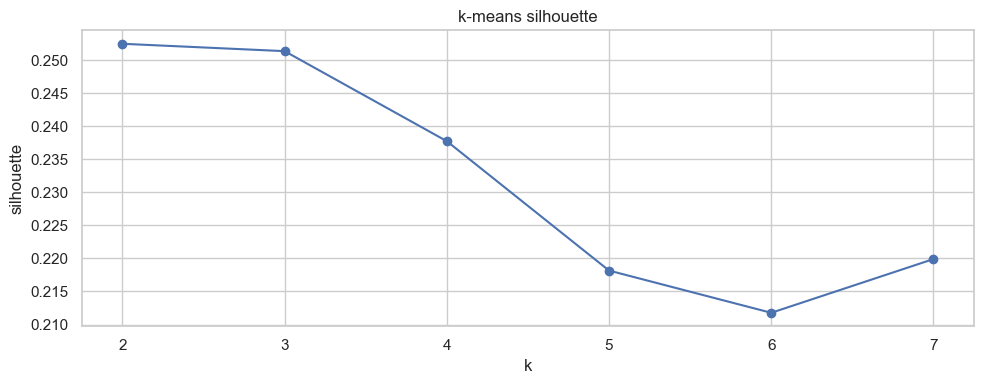

In [10]:
ks = range(2, 8)
scores = []
for k in ks:
    km = KMeans(n_clusters=k, random_state=SEED)
    labels = km.fit_predict(Xz)
    sc = silhouette_score(Xz, labels)
    scores.append(sc)
plt.figure(); plt.plot(list(ks), scores, '-o'); plt.xlabel('k'); plt.ylabel('silhouette'); plt.title('k-means silhouette'); plt.grid(True); plt.tight_layout(); plt.savefig(RESULTS_DIR / 'kmeans_silhouette.png', dpi=150)
print('Saved kmeans_silhouette.png')
# attach best cluster assignment to features_df
best_k = ks[int(np.argmax(scores))]
best_k
km = KMeans(n_clusters=best_k, random_state=SEED).fit(Xz)
features_df['cluster'] = km.labels_
features_df.to_csv(RESULTS_DIR / 'features_with_clusters.csv', index=False)
print('Saved features_with_clusters.csv')

## 10) Simple classifier baseline with cross-validation
If labels (species) exist, train a simple RandomForest baseline using StratifiedKFold. Save results and a fitted model.

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix

y = features_df['species'].values
Xf = Xz
if len(np.unique(y))>1 and Xf.shape[0]>10:
    cv = StratifiedKFold(n_splits=min(5, len(np.unique(y))))
    clf = RandomForestClassifier(n_estimators=200, random_state=SEED, n_jobs=-1)
    scores = cross_val_score(clf, Xf, y, cv=cv, scoring='f1_macro')
    print('CV macro-F1:', scores, 'mean=', np.mean(scores))
    # fit on full data and save
    clf.fit(Xf, y)
    joblib.dump(clf, RESULTS_DIR / 'rf_baseline_spectrograms.joblib')
    print('Saved RF model')
else:
    print('Not enough labeled data to run baseline')

CV macro-F1: [0.32460864 0.38371166 0.34518015 0.35760538 0.33625305] mean= 0.3494717760487262
Saved RF model
Saved RF model


## 11) Playback and inverse spectrogram (Griffin-Lim)
Provide functions to invert magnitude spectrograms back to waveforms and play them inline for quick sanity checks.

In [15]:
from IPython.display import Audio
def invert_and_play(S, sr=22050, requested_n_fft=1024, hop_length=512, n_iter=32):
    # assume S is power spectrogram (magnitude^2) or magnitude; librosa.griffinlim expects magnitude
    S = np.asarray(S, dtype=float)
    # if values are log-power (e.g. dB), try to convert back to amplitude
    if np.nanmin(S) < 0 and np.nanmax(S) <= 0:
        try:
            mag = librosa.db_to_amplitude(S)
        except Exception:
            mag = np.expm1(S)
    else:
        mag = np.abs(S)
    # determine an n_fft compatible with the spectrogram shape: n_fft = (n_freq_bins - 1) * 2
    if mag.ndim == 2:
        n_freq_bins = mag.shape[0]
    elif mag.ndim == 1:
        n_freq_bins = mag.shape[0]
    else:
        raise ValueError('Unsupported spectrogram shape for inversion')
    inferred_n_fft = max(2, (int(n_freq_bins) - 1) * 2)
    # choose final n_fft and win_length so win_length <= n_fft (librosa requirement)
    n_fft = inferred_n_fft
    win_length = min(requested_n_fft, n_fft)
    # adjust hop_length if it's too large relative to n_fft
    hop_length = min(hop_length, max(1, win_length // 4))
    # run griffin-lim with consistent parameters
    y = librosa.griffinlim(mag, n_iter=n_iter, hop_length=hop_length, win_length=win_length, n_fft=n_fft)
    return y

# Example: pick first file and play (if available)
if len(spec_paths) > 0:
    p = spec_paths[0]
    out = load_spectrogram(p)
    try:
        y = invert_and_play(out['S'])
        display(Audio(y, rate=22050))
    except Exception as ex:
        print('Inversion failed:', ex)

## 12) Save plots, features, and results
All produced artifacts are saved under `results/` with timestamps. See earlier cells for saved filenames.

## 13) Automated unit tests (pytest)
Add light pytest tests under `tests/` to validate key functions: `load_spectrogram`, `extract_features_from_S`, and `invert_and_play`. Example tests can be small smoke tests that load 1-3 files.

## 14) Reproducibility: seeds & package versions
Print seeds and package versions used for this run and save a copy of `pip freeze` output if desired.

In [17]:
# Attempt to gather installed package versions using importlib.metadata (stdlib) with a pkg_resources fallback
try:
    import importlib.metadata as importlib_metadata
    # build a dict of package name -> version (lowercased keys)
    pkgs = { (d.metadata.get('Name') or '').lower(): d.version for d in importlib_metadata.distributions() if (d.metadata.get('Name') or '').strip() }
except Exception:
    try:
        import pkg_resources
        pkgs = {p.key: p.version for p in pkg_resources.working_set}
    except Exception:
        pkgs = {}
ver_json = RESULTS_DIR / f'versions_{int(time.time())}.json'
# Choose a small set of packages to record (if available)
keys = ['numpy','pandas','librosa','scikit-learn','umap-learn']
versions = {}
for k in keys:
    v = None
    # try common key variants
    for variant in (k, k.lower(), k.replace('-', '_')):
        if variant in pkgs:
            v = pkgs[variant]; break
    if v is None:
        # fallback: case-insensitive search
        for name, val in pkgs.items():
            if name and name.lower() == k.lower():
                v = val; break
    if v is not None:
        versions[k] = v
ver_json.write_text(json.dumps({'seed': SEED, 'packages': versions}, indent=2))
print('Wrote versions file to', ver_json)

Wrote versions file to C:\Users\Darling\DATA SCIENCE PROJECTS\VSCodeProjects\GA_Frog_ID_Data_Prep\results\versions_1762228623.json
